<a href="https://colab.research.google.com/github/sohiniroych/QU-net-Plus-Plus/blob/main/Unet_plus_binary_Baseline_OCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This code implements segmentation of of cysts from OCT images using the variants of U-net, wUnet and Unet++

## This code implements multi-class classification
## This model is adapted from the original codebase in https://github.com/HZCTony/U-net-with-multiple-classification

In [ ]:
# First lets connect the Gdrive that contains the data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
# The path below should point to the directory containing this notebook and the associated utility files
# Change it if necessary
os.chdir('/content/drive/MyDrive/Colab Notebooks/ISBI_paper/code/')
!ls
PATH='/content/drive/My Drive/Colab Notebooks/ISBI_paper/Data_Stacks/cirrus_2/test/'

Data_pipeline_Medical_data.ipynb  Unet_plus_binary-Baseline_Lung_med.ipynb
model_new.py			  Unet_plus_binary-Baseline_Lung_rad.ipynb
__pycache__			  Unet_plus_binary-Baseline_OCT.ipynb
train				  Unet_plus_binary.ipynb


# First, we create a directry of randomly sampled training and test images

In [ ]:
# if not os.path.exists(PATH+'train'):
#     os.makedirs(PATH+'train')
# if not os.path.exists(PATH+'train/Image/'):
#     os.makedirs(PATH+'train/Image/')
# if not os.path.exists(PATH+'train/GT/'):
#     os.makedirs(PATH+'train/GT/')
    
# if not os.path.exists(PATH+'test'):
#     os.makedirs(PATH+'test')    
# if not os.path.exists(PATH+'test/Image/'):
#     os.makedirs(PATH+'test/Image/')
# if not os.path.exists(PATH+'test/GT/'):
#     os.makedirs(PATH+'test/GT/')
    
# if not os.path.exists(PATH+'pred'):
#    os.makedirs(PATH+'pred')  



# Randomly split the data in "Images" into 25/75

In [ ]:
files=(os.listdir(PATH+'/Image/'))
print(len(files))

25


In [ ]:
# import numpy as np 
# nums=np.random.permutation(len(files))
# n=int(len(files)/4)
# print(n)

In [ ]:
# from shutil import copyfile

# #This is train data
# for i in range(n):
#     copyfile(PATH+'Image/'+files[nums[i]],PATH+'train/Image/'+files[nums[i]])
#     copyfile(PATH+'GT/'+files[nums[i]],PATH+'train/GT/'+files[nums[i]])
    

In [ ]:
# # This is test data
# for i in range(n+1,len(files)):
#     copyfile(PATH+'Image/'+files[nums[i]],PATH+'test/Image/'+files[nums[i]])
#     copyfile(PATH+'/GT/'+files[nums[i]],PATH+'test/GT/'+files[nums[i]])

In [ ]:
# os.getcwd()

# Train and Test data are now generated. Now we need to train and test

# A. Lets start by stepwise defining all libraries and functions needed to generate the model and pre-process the data

In [ ]:
#Step 1: Load libraries for the U-net Model

import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
#from tensorflow import keras
import tensorflow as tf

In [ ]:
#Step 2: Import the U-net model
from model_new import *
img_size=(256,256)

In [ ]:
n_class=2


In [ ]:
#mod = #U_Net(img_size[0],img_size[1],1)
mod = Nest_Net(img_size[0],img_size[1],1,1,deep_supervision=True)

In [ ]:
mod.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv11_1 (Conv2D)               (None, 256, 256, 32) 320         main_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv11_1[0][0]                   
__________________________________________________________________________________________________
conv11_2 (Conv2D)               (None, 256, 256, 32) 9248        batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
#Step 3:Define functions for pre-processing data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
import scipy.misc as sc


def adjustData(img,mask,flag_multi_class,n_class):
    
    if(flag_multi_class):
        img /= 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (n_class,))
        for i in range(n_class):
            
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img)>1):
        img = img / 255
        mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <=0.5] = 0
        #print(np.shape(mask),np.shape(img))
    return (img,mask)



def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,n_class = n_class,save_to_dir = None,target_size = img_size,seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        #'./',
        train_path,
        classes = [image_folder],
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        class_mode=None,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        class_mode=None,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,n_class)
        yield (img,mask)


def testGenerator(test_path,target_size = img_size,flag_multi_class = True,as_gray = True):
    files=sorted(os.listdir(test_path))
    num_image=len(files)
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,files[i]),as_gray = as_gray)
        print(files[i])
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        #print(np.max(img))
        yield img

In [ ]:
#Step 4: Define function to save the test images
def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i] = color_dict[i]
      
    return img_out


def saveResult(img_path,save_path,npyfile,flag_multi_class = False,num_class = 2):
    files=os.listdir(img_path)
    #print(len(img_path))
    #print(len(npyfile))
    
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        #img1=np.array(((img - np.min(img))/np.ptp(img))>0.6).astype(float)
        img[img>0.5]=1
        img[img<=0.5]=0
        io.imsave(os.path.join(save_path, files[i]),img)
        
        
        
def SaveResultwImage(img_path,save_path,npyfile,target_size=img_size,flag_multi_class = False,num_class = 2):
    files=os.listdir(img_path)
    #print(len(img_path))
    #print(len(npyfile))
    
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        #img1=np.array(((img - np.min(img))/np.ptp(img))>0.6).astype(float)
        img[img>0.2]=1
        img[img<=0.2]=0
        
        I = io.imread(os.path.join(img_path,files[i]), as_gray=True)
        I = trans.resize(I,target_size)
        #dst = cv2.addWeighted(img, 0.5, I, 0.5, 0.0)
        img=np.true_divide((I+img),2)
        io.imsave(os.path.join(save_path, files[i]),img)  

In [ ]:
#Step 5: Define functions to evaluate the output
import sklearn.metrics as sm

def get_confusion_matrix_elements(groundtruth_list, predicted_list):
    """returns confusion matrix elements i.e TN, FP, FN, TP as floats
	See example code for helper function definitions
    """
    tn, fp, fn, tp = sm.confusion_matrix(groundtruth_list, predicted_list,labels=[0,1]).ravel()
    tn, fp, fn, tp = np.float64(tn), np.float64(fp), np.float64(fn), np.float64(tp)

    return tn, fp, fn, tp

def get_prec_rec_IoU_accuracy(groundtruth_list, predicted_list):
    """returns precision, recall, IoU and accuracy metrics
	"""
    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)
    
    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total
    prec=tp/(tp+fp)
    rec=tp/(tp+fn)
    IoU=tp/(tp+fp+fn)
    
    return prec,rec,IoU,accuracy

def get_f1_score(groundtruth_list, predicted_list):
    """Return f1 score covering edge cases"""

    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)
    
    f1_score = (2 * tp) / ((2 * tp) + fp + fn)

    return f1_score

def get_validation_metrics(groundtruth,predicted):
    """Return all output metrics. Input is binary images"""
   
    u,v=np.shape(groundtruth)
    groundtruth_list=np.reshape(groundtruth,(u*v,))
    predicted_list=np.reshape(predicted,(u*v,))
    prec,rec,IoU,acc=get_prec_rec_IoU_accuracy(groundtruth_list, predicted_list)
    f1_score=get_f1_score(groundtruth_list, predicted_list)
   # print("Precision=",prec, "Recall=",rec, "IoU=",IoU, "acc=",acc, "F1=",f1_score)
    return prec,rec,IoU,acc,f1_score

def evalResult(gth_path,npyfile,target_size=img_size,flag_multi_class = False,num_class = 2):
    files=sorted(os.listdir(gth_path))
    #print(files)
    prec=0
    rec=0
    acc=0
    IoU=0
    f1_score=0
    for i,item in enumerate(npyfile):
        img = item[:,:,0]
        gth = io.imread(os.path.join(gth_path,files[i]))
        gth = trans.resize(gth,target_size)
        if(np.sum(img)>0):
            img=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
        if(np.sum(gth)>0):
            gth=np.array(((gth - np.min(gth))/np.ptp(gth))>0.1).astype(float)
            gth=(gth>0.1).astype(int)
        #print(np.shape(gth),np.shape(img))
        p,r,I,a,f=get_validation_metrics(gth,img)
        if (np.isnan(p)):
          p=1
        if (np.isnan(r)):
          r=1
        if (np.isnan(f)):
          f=1
        if (np.isnan(I)):
          I=1
        prec=prec+p
        rec=rec+r
        acc=acc+a
        IoU=IoU+I
        f1_score=f1_score+f
    print("Precision=",prec/(i+1), "Recall=",rec/(i+1), "Jac=",IoU/(i+1), "acc=",acc/(i+1), "Dice=",f1_score/(i+1))   

# All definitions are now done! Lets start using the functions now...
# B. Call to image data generator, model initialization, followed by model fitting.

In [ ]:
#Step 1: Call to image data generator in keras

os.chdir('/content/drive/MyDrive/Colab Notebooks/ISBI_paper/Data_Stacks/cirrus_2/test/')
data_gen_args = dict(rotation_range=0.2,
                    rescale=1./255,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.1,
                    zoom_range=[0.8,1],
                    horizontal_flip=False,
                    vertical_flip=False,
                    fill_mode='nearest')
PATH='./train/'

In [ ]:
data_gen = trainGenerator(3,PATH,'Image','GT',data_gen_args, save_to_dir = None)

In [ ]:

# data_gen = trainGenerator(1,PATH,'Image','GT',data_gen_args, save_to_dir = None)
# for e in range(5):
#     print('Epoch', e)
#     batches = 0
#     for x_batch, y_batch in data_gen:
#         print(np.max(x_batch))
#         plt.imshow(np.squeeze(x_batch), cmap=plt.get_cmap('gray'))
        

#         plt.show()
        
#         break

In [ ]:
#Step 2: Initialize the model. Train from scratch!
# Initialize model like you usually do.
#tf.keras.backend.clear_session()
#mod.compile(optimizer = Adam(learning_rate=0.00001), loss = bce_dice_loss, metrics = dice_coef)
#mod.compile(optimizer = Adam(learning_rate=0.0001), loss = "binary_crossentropy", metrics = "acc")
mod.compile(optimizer = Adam(learning_rate=0.00001), loss = dice_coef_loss, metrics = dice_coef)

In [ ]:
# Notice WandbCallback is used as a regular callback
# We again use config
hist = mod.fit(data_gen,steps_per_epoch=15,epochs=60,verbose=1)
          #        mod.fit(x_train, y_train,
          # epochs=50, 
          # batch_size=5, verbose=1)

Found 6 images belonging to 1 classes.
Found 6 images belonging to 1 classes.
Epoch 1/60
15/15 [==============================] - 7s 83ms/step - loss: -0.1017 - output_1_loss: -0.0242 - output_2_loss: -0.0280 - output_3_loss: -0.0271 - output_4_loss: -0.0223 - output_1_dice_coef: 0.0242 - output_2_dice_coef: 0.0280 - output_3_dice_coef: 0.0271 - output_4_dice_coef: 0.0223
Epoch 2/60
15/15 [==============================] - 1s 84ms/step - loss: -0.1199 - output_1_loss: -0.0288 - output_2_loss: -0.0330 - output_3_loss: -0.0310 - output_4_loss: -0.0271 - output_1_dice_coef: 0.0288 - output_2_dice_coef: 0.0330 - output_3_dice_coef: 0.0310 - output_4_dice_coef: 0.0271
Epoch 3/60
15/15 [==============================] - 1s 85ms/step - loss: -0.1347 - output_1_loss: -0.0323 - output_2_loss: -0.0376 - output_3_loss: -0.0339 - output_4_loss: -0.0309 - output_1_dice_coef: 0.0323 - output_2_dice_coef: 0.0376 - output_3_dice_coef: 0.0339 - output_4_dice_coef: 0.0309
Epoch 4/60
15/15 [=============

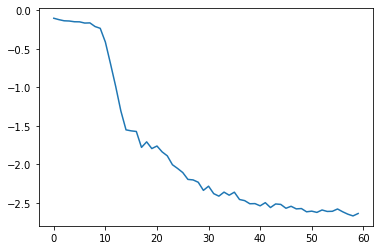

In [ ]:
# plt.plot(hist.history['output_1_loss'])
# plt.plot(hist.history['output_2_loss'])
# plt.plot(hist.history['output_3_loss'])
# plt.plot(hist.history['output_4_loss'])
# plt.xlabel('Epochs')
# plt.ylabel('Level Loss')
plt.plot(hist.history['loss'])

# Generate results!

In [ ]:
PATH

'./train/'

In [ ]:
#Step 1: Run model on test images and save the images
#number of test images
n_i=len(os.listdir('./test/Image/'))
#Call test generator
test_gen= testGenerator('./test/Image/')
print(n_i)


18


In [ ]:
#Return model outcome for each test image
results = mod.predict_generator(test_gen,n_i,verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


bscan_69.jpg
bscan_70.jpg
18/18 [==============================] - 5s 261ms/step


In [ ]:
#lung_masks=np.load('masks.npy')

In [ ]:
# plt.imshow(1-lung_masks[0][:,:,3])
# print(np.shape(results), np.shape(lung_masks))

# Next, we need to mask each result and evaluate on test data only

In [ ]:
# def evalResult_with_masks(gth_path,npyfile,masks,num_test,target_size=img_size,flag_multi_class = False,num_class = 2):
#     files=sorted(os.listdir(gth_path))
#     #print(files)
#     prec=0
#     rec=0
#     acc=0
#     IoU=0
#     f1_score=0
#     for i,item in enumerate(npyfile):
#       img = item[:,:,0]
#       if i in num_test:
#           gth = io.imread(os.path.join(gth_path,files[nums[i]]))
#           mask=1-masks[i][:,:,3]
#           mask=trans.resize(mask,target_size)
#           gth = trans.resize(gth,target_size)
#           img=img*mask
#           if(np.sum(img)>0):
#               img=np.array(((img - np.min(img))/np.ptp(img))>0.5).astype(float)
#           if(np.sum(gth)>0):
#               gth=np.array(((gth - np.min(gth))/np.ptp(gth))>0.5).astype(float)
#               gth=(gth>0.5).astype(int)
#           #print(np.shape(gth),np.shape(img))
#           p,r,I,a,f=get_validation_metrics(gth[:,:,1],img)
#       if (np.isnan(p)):
#               p=1
#       if (np.isnan(r)):
#               r=1
#       if (np.isnan(f)):
#               f=1
#       if (np.isnan(I)):
#               I=1
#       prec=prec+p
#       rec=rec+r
#       acc=acc+a
#       IoU=IoU+I
#       f1_score=f1_score+f
#     print("Precision=",prec/len(num_test), "Recall=",rec/len(num_test), "Jac=",IoU/len(num_test), "acc=",acc/len(num_test), "Dice=",f1_score/len(num_test))   

In [ ]:
#Lets save the STARE predictions
# saveResult('./test/Image/','./pred/',results)

In [ ]:
#evalResult('./test/GT/',results)

0.9997025 1.7763273e-09


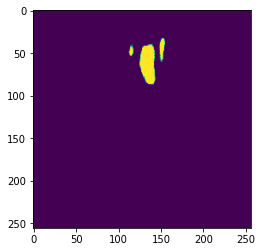

In [ ]:
#Lets visualize the STARE predictions
plt.imshow(results[3][3][:,:,0])
print(np.max(results[0]),np.min(results[0]))

In [ ]:
evalResult('./test/GT/',results[0])

Precision= 0.03085188343718049 Recall= 0.8816006263476709 Jac= 0.0308409472245455 acc= 0.3347829182942708 Dice= 0.05899622698087329


In [ ]:
evalResult('./test/GT/',results[1])

Precision= 0.6138064920740696 Recall= 0.716218153356238 Jac= 0.5311774784347616 acc= 0.9899266560872396 Dice= 0.6386218686274427


In [ ]:
evalResult('./test/GT/',results[2])

Precision= 0.6901807137728546 Recall= 0.6194155148939319 Jac= 0.5681731316951598 acc= 0.9933827718098959 Dice= 0.6458405192488543


In [ ]:
evalResult('./test/GT/',results[3])

Precision= 0.7142364867931595 Recall= 0.6228841872716444 Jac= 0.5814944166984373 acc= 0.9940600925021701 Dice= 0.6554733177841938


0.9997025 1.7763273e-09


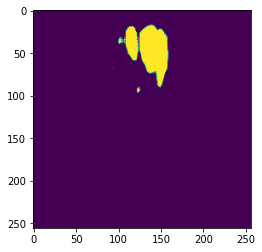

In [ ]:
#Lets visualize the STARE predictions
plt.imshow(results[3][8][:,:,0])
print(np.max(results[0]),np.min(results[0]))

In [ ]:
def return_Unet_result_layers(files,img_path, results,num):
  I=io.imread(os.path.join(img_path,files[num]), as_gray=True)
  I = trans.resize(I,img_size)
  pred0=(results[0][num][:,:,0]>0.5).astype(int)
  pred1=(results[1][num][:,:,0]>0.5).astype(int)
  pred2=(results[2][num][:,:,0]>0.5).astype(int)
  pred3=(results[3][num][:,:,0]>0.5).astype(int)
  f, axarr = plt.subplots(2,2)
  axarr[0,0].imshow(np.true_divide((I+pred0),2))
  axarr[0,1].imshow(np.true_divide((I+pred1),2))
  axarr[1,0].imshow(np.true_divide((I+pred2),2))
  axarr[1,1].imshow(np.true_divide((I+pred3),2))
  return pred2,pred3

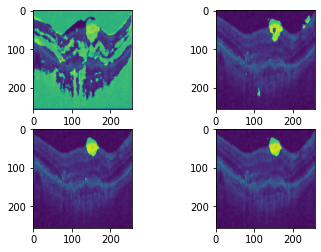

In [ ]:
pred2,pred3=return_Unet_result_layers(os.listdir('./test/Image/'),'./test/Image/',results,13)


In [ ]:
# Function to count how manu images have low quality score
def compute_fraction_of_low_q(results,n_i):
  J=np.zeros(n_i)
  for i in range(n_i):
    pred2=(results[2][i][:,:,0]>0.5).astype(int)
    pred3=(results[3][i][:,:,0]>0.5).astype(int)
    prec,rec,J[i],acc,f1_score=get_validation_metrics(pred3,pred2)
  return J


In [ ]:
#get_validation_metrics(pred3,pred2)
J=compute_fraction_of_low_q(results,n_i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
imgs=np.where(J<=0.5)
np.shape(imgs)[1]

2

In [ ]:
def print_top2bottom(gth_path,img_path, npyfile,target_size=img_size,flag_multi_class = False,num_class = 2):
    files=sorted(os.listdir(gth_path))
    #print(files)
    fin_image=np.zeros((256,256,3))
    for i,item in enumerate(npyfile):
        print(i)
        img = item[:,:,0]
        gth = io.imread(os.path.join(gth_path,files[i]))
        gth = trans.resize(gth,target_size)
        I=   io.imread(os.path.join(img_path,files[i]), as_gray=True)
        I = trans.resize(I,img_size)
        #print(np.shape(gth))
        if(np.sum(img)>0):
            img=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
        if(np.sum(gth)>0):
            gth=np.array(((gth - np.min(gth))/np.ptp(gth))>0.1).astype(float)
            gth=(gth>0.9).astype(int)
        #print(np.shape(gth),np.shape(img))
        p,r,j,a,f=get_validation_metrics(gth,img)
        
        if (j>0.1 and j<0.3):
          print(p,r,j,a,f)
          fin_image[:,:,1]=I
          fin_image[:,:,0]=gth
          fin_image[:,:,2]=img
          plt.imshow(fin_image)
          break


0
1
2
0.8087431693989071 0.23088923556942278 0.21893491124260356 0.991943359375 0.3592233009708738


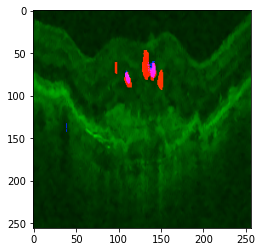

In [ ]:
print_top2bottom('./test/GT/','./test/Image/', results[3])